# Causal Inference - Exercise (IHDP)

> Bloque con sangría



This is an opportunity for everyone to put into practice everything we have learnt so far. The data for this exercise comes from Infant Health Development Program study and was modified specifically for causal inference estimation purposes. More precisely, this dataset was formally introduced by [Hill (2011)](https://doi.org/10.1198/jcgs.2010.08162). It is a commonly used semi-simulated dataset in the CI community that combines pre-treatment covariates (X) and treatment assignments (T) from a real study, and simulated outcomes (Y). Because all outcomes are generated (both $y_1$ and $y_0$), we can measure individual as well as average treatment effect errors. For training purposes, only one of the outcomes is available to the estimator. The other is hidden and used only for evaluation purposes.

The experiment where the covariates come from measured various aspects of premature infants and their mothers, and how receiving specialised childcare affected the cognitive test score of the infants later on. The treatment groups are made imbalanced by removing a subset of the treated individuals. The variables are a mixture of contonuous and binary features. Treatment is binary. The outcome Y is continuous. Overall, we have 25 background features X. The data consists of 747 samples (139 treated, 608 control).

In terms of evaluation metrics, we are interested in predicting both individual and average treatment effects for this task. As the outcomes are simulated, we have access to both true outcomes $\mathcal{Y}_1$ and $\mathcal{Y}_0$ for each individual (i). As a result, we have access to true ITEs and true ATE:

$$ITE^{(i)} = \mathcal{Y}_1^{(i)} - \mathcal{Y}_0^{(i)}$$

$$ATE = \mathbb{E}[ITE]$$

We can define our predictions as:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

This allows us to define measurement errors with respect to each as:

$$\epsilon_{PEHE} = \sqrt{\frac{1}{n}\sum \limits_{i=1}^{n}(\widehat{ITE}^{(i)} - ITE^{(i)})^2}$$

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

Where PEHE stands for Precision in Estimation of Heterogeneous Effect, and which essentially is a Root Mean Squared Error (RMSE) between predicted and true ITEs. Implementations of both metrics are provided below.

In [1]:
def rmse(a, b):
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

We suggest the following steps:
1. Import packages.
    1. Remember to install EconML if you want to use it.
2. Data.
    1. Can be accessed at the following URLs:
        1. Training: https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz
        2. Testing: https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_test.npz
    2. Use 'wget' command to download them into the notebook (or upload manually).
    3. Explore the data (print a few samples, plot distributions - see plot_dist function below).
3. Data pre-processing.
    1. No data splitting required (train and test already provided).
    2. Scaling.
4. Train estimators of your choice (re-use already presented ones or explore different methods.
  1. EconML - [CATE estimators](https://econml.azurewebsites.net/reference.html#cate-estimators).
  2. scikit-learn - [supervised methods](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
5. Make predictions.
6. Evaluate your models.
    1. Measure ATE and PEHE errors.

In [7]:
!pip install econml


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 164 kB 54.4 MB/s 
     |████████████████████████████████| 564 kB 45.9 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [12]:
#Importando las Librerias
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt


In [10]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10):
    """
    data: 2-dimensional numpy array
    bins: number of bins in the histograms
    """
    if data.shape[1] > 1:
        sq = math.sqrt(data.shape[1])
        d_ceil = math.ceil(sq)
        d_floor = math.floor(sq)

        if (d_ceil * d_floor) >= data.shape[1]:
            n_rows = d_floor
            n_cols = d_ceil
        else:
            n_rows = n_cols = d_ceil

        _, axs = plt.subplots(n_rows, n_cols)
        axs = _trim_axs(axs, data.shape[1])

        for i, ax in enumerate(axs):
            ax.hist(data[:, i], bins=bins)
    else:
        plt.hist(data, bins=bins)
    
    plt.show()

In [11]:
#Obteniendo la data

!wget https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz

--2022-07-28 13:53:16--  https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_train.npz
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_train.npz [following]
--2022-07-28 13:53:17--  https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151488 (148K) [application/octet-stream]
Saving to: ‘ihdp_train.npz’

ihdp_train.npz      100%[===================>] 147.94K  --.-KB/s    in 0.02s   

2022-07-

In [13]:
#Obteniendo la data

!wget https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_test.npz

--2022-07-28 13:54:32--  https://github.com/dmachlanski/iads-summer-school-causality-2022/raw/main/labs/data/ihdp_test.npz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_test.npz [following]
--2022-07-28 13:54:33--  https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2022/main/labs/data/ihdp_test.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17760 (17K) [application/octet-stream]
Saving to: ‘ihdp_test.npz’

ihdp_test.npz       100%[===================>]  17.34K  --.-KB/s    in 0.001s  

2022-07-28 13:

In [15]:
data_1 = np.load('/content/ihdp_train.npz')

In [16]:
data_2 = np.load('/content/ihdp_test.npz')

In [17]:
data_1.files

['x', 't', 'y', 'te']

In [18]:
data_2.files

['x', 't', 'y', 'te']

In [19]:
for f in data_1.files:
  print(f'{f}: {data_1[f].shape}')

x: (672, 25)
t: (672, 1)
y: (672, 1)
te: (672, 1)


In [20]:
for f in data_2.files:
  print(f'{f}: {data_2[f].shape}')

x: (75, 25)
t: (75, 1)
y: (75, 1)
te: (75, 1)


In [30]:
X = data_1['x'].reshape(672, 25)
T = data_1['t'].reshape(-1, 1)
Y = data_1['y'].reshape(-1, 1)
TE = data_1['te'].reshape(-1, 1)

In [31]:
X1 = data_2['x'].reshape(75, 25)
T2 = data_2['t'].reshape(-1, 1)
Y3 = data_2['y'].reshape(-1, 1)
TE1 = data_2['te'].reshape(-1, 1)

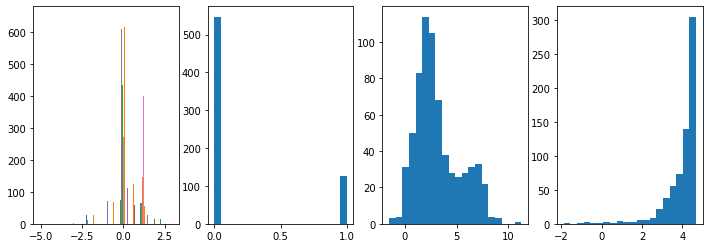

In [32]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(TE, bins=bins)
plt.show()

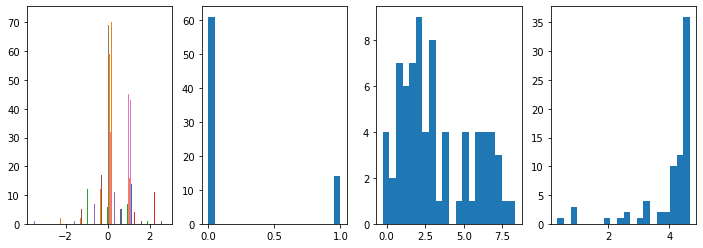

In [33]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].hist(X1, bins=bins)
axs[1].hist(T2, bins=bins)
axs[2].hist(Y3, bins=bins)
axs[3].hist(TE1, bins=bins)
plt.show()

In [39]:
#x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(X, T, Y,TE, test_size=0.2)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
X1 = scaler_x.transform(X1)

In [40]:
# Random Forest
rf = RandomForestRegressor()

# Train on the training data.
# In the supervised setting, our usual X here consists of X and T.
# The target is Y - the outcome.
# Input: [X, T], output: Y.
rf.fit(np.concatenate([X, T], axis=1), Y.flatten())

# Predictions
# Note we set T to a specific value for ALL individuals.
# These are interventional distributions - P(Y|X, do(T=t)).

# Training predictions:
# Predict Y_0 given [X, 0]
rf_y0_in = rf.predict(np.concatenate([X, np.zeros_like(T)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_in = rf.predict(np.concatenate([X, np.ones_like(T)], axis=1))

# Test predictions (model's generalisation to unseen examples):
# Predict Y_0 given [X, 0]
rf_y0_out = rf.predict(np.concatenate([X1, np.zeros_like(T2)], axis=1))
# Predict Y_1 given [X, 1]
rf_y1_out = rf.predict(np.concatenate([X1, np.ones_like(T2)], axis=1))

# Compute ITEs (training and test)
# ITE = Y_1 - Y_0
rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

In [41]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

In [42]:
# Get the sample weights
prop_clf = RandomForestClassifier()
weights = get_ps_weights(prop_clf, X, T)

# Train the regressor
rf_ipsw = RandomForestRegressor()
rf_ipsw.fit(np.concatenate([X, T], axis=1), Y.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([X, np.zeros_like(T)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([X, np.ones_like(T)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([X1, np.zeros_like(T2)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([X1, np.ones_like(T2)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out


In [50]:
weights.shape

In [48]:
# X-Learner
xl = XLearner(models=RandomForestRegressor(), propensity_model=RandomForestClassifier())
xl.fit(Y, T.flatten(), X=X)

xl_te_in = xl.effect(X)
xl_te_out = xl.effect(X1)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [73]:
true_ate = 1.05

rf_ate_in = ate_error(rf_te_in, TE)
rf_ate_out = ate_error(rf_te_out, TE1)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, TE)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, TE1)

xl_ate_in = ate_error(xl_te_in, TE)
xl_ate_out = ate_error(xl_te_out, TE1)

In [74]:
results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE train,ATE test
0,RF,0.075012,0.050441
1,RF (IPW),0.050026,0.008679
2,XL,0.019815,0.018291


In [75]:
def mean_ci(data, ci=0.95):
  l_mean = np.mean(data)
  lower, upper = st.t.interval(ci, len(data)-1, loc=l_mean, scale=st.sem(data))
  return l_mean, lower, upper

In [76]:
rf_ate_bounds = mean_ci(rf_te_out)
rf_ipsw_ate_bounds = mean_ci(rf_ipsw_te_out)
xl_ate_bounds = mean_ci(xl_te_out)

results = []
results.append(['RF', rf_ate_bounds[0], rf_ate_bounds[1], rf_ate_bounds[2]])
results.append(['RF (IPW)', rf_ipsw_ate_bounds[0], rf_ipsw_ate_bounds[1], rf_ipsw_ate_bounds[2]])
results.append(['XL', xl_ate_bounds[0], xl_ate_bounds[1], xl_ate_bounds[2]])

cols = ['Method', 'ATE mean', 'CI lower', 'CI upper']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE mean,CI lower,CI upper
0,RF,3.980108,3.733665,4.226551
1,RF (IPW),4.039228,3.781382,4.297075
2,XL,4.048840,[3.8700726129992167],[4.227606398150699]


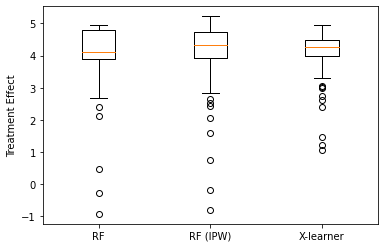

In [77]:
plt.figure()
plt.boxplot([rf_te_out, rf_ipsw_te_out, xl_te_out.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

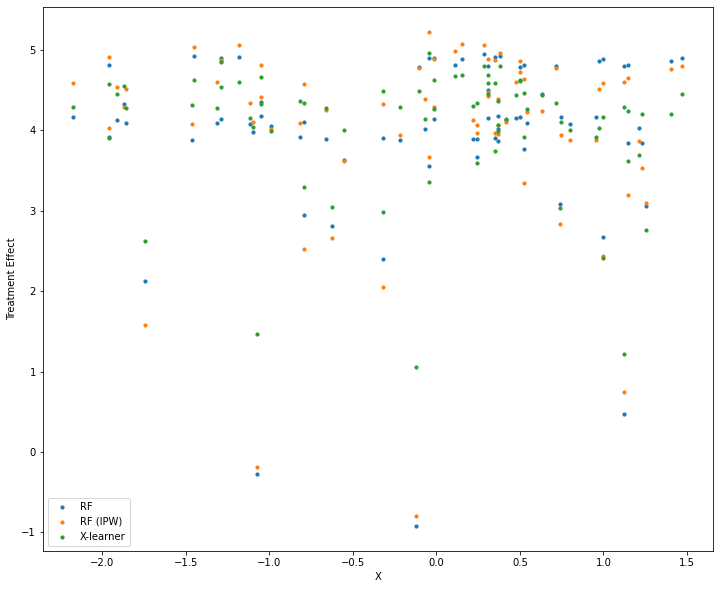

In [78]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(X1[:, 0], rf_te_out, label="RF", s= m_size)
plt.scatter(X1[:, 0], rf_ipsw_te_out, label="RF (IPW)", s=m_size)
plt.scatter(X1[:, 0], xl_te_out, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

In [62]:
# Defines parameter search space for Random Forests.
params = {"max_leaf_nodes": [10, 20, 30, None], "max_depth": [5, 10, 20, None]}

In [79]:
rf = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)

rf.fit(np.concatenate([X, T], axis=1), Y.flatten())

rf_y0_in = rf.predict(np.concatenate([X, np.zeros_like(T)], axis=1))
rf_y1_in = rf.predict(np.concatenate([X, np.ones_like(T)], axis=1))

rf_y0_out = rf.predict(np.concatenate([X1, np.zeros_like(T2)], axis=1))
rf_y1_out = rf.predict(np.concatenate([X1, np.ones_like(T2)], axis=1))

rf_te_in = rf_y1_in - rf_y0_in
rf_te_out = rf_y1_out - rf_y0_out

In [80]:
prop_clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)
weights = get_ps_weights(prop_clf, X, T)

rf_ipsw = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
rf_ipsw.fit(np.concatenate([X, T], axis=1), Y.flatten(), sample_weight=weights)

rf_ipsw_y0_in = rf_ipsw.predict(np.concatenate([X, np.zeros_like(T)], axis=1))
rf_ipsw_y1_in = rf_ipsw.predict(np.concatenate([X, np.ones_like(T)], axis=1))

rf_ipsw_y0_out = rf_ipsw.predict(np.concatenate([X1, np.zeros_like(T2)], axis=1))
rf_ipsw_y1_out = rf_ipsw.predict(np.concatenate([X1, np.ones_like(T2)], axis=1))

rf_ipsw_te_in = rf_ipsw_y1_in - rf_ipsw_y0_in
rf_ipsw_te_out = rf_ipsw_y1_out - rf_ipsw_y0_out

In [81]:
reg = GridSearchCV(RandomForestRegressor(), param_grid=params, n_jobs=-1, cv=5)
clf = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5)

xl = XLearner(models=reg, propensity_model=clf)
xl.fit(Y, T.flatten(), X=X)

xl_te_in = xl.effect(X)
xl_te_out = xl.effect(X1)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [82]:
true_ate = 1.05

rf_ate_in = ate_error(rf_te_in, TE)
rf_ate_out = ate_error(rf_te_out, TE1)

rf_ipsw_ate_in = ate_error(rf_ipsw_te_in, TE)
rf_ipsw_ate_out = ate_error(rf_ipsw_te_out, TE1)

xl_ate_in = ate_error(xl_te_in, TE)
xl_ate_out = ate_error(xl_te_out, TE1)

results = []
results.append(['RF', rf_ate_in, rf_ate_out])
results.append(['RF (IPW)', rf_ipsw_ate_in, rf_ipsw_ate_out])
results.append(['XL', xl_ate_in, xl_ate_out])

cols = ['Method', 'ATE train', 'ATE test']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE train,ATE test
0,RF,0.070007,0.033705
1,RF (IPW),0.068274,0.016940
2,XL,0.000268,0.048087


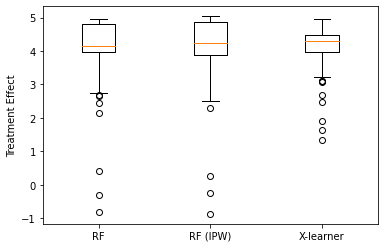

In [83]:
plt.figure()
plt.boxplot([rf_te_out, rf_ipsw_te_out, xl_te_out.flatten()], labels=['RF', 'RF (IPW)', 'X-learner'])
plt.ylabel('Treatment Effect')

plt.show()

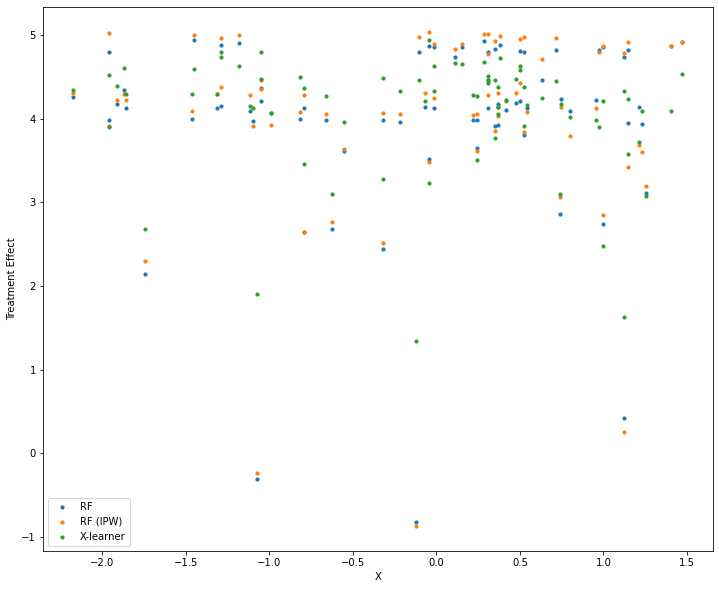

In [85]:
plt.figure(figsize=(12, 10))
m_size = 10
plt.scatter(X1[:, 0], rf_te_out, label="RF", s= m_size)
plt.scatter(X1[:, 0], rf_ipsw_te_out, label="RF (IPW)", s=m_size)
plt.scatter(X1[:, 0], xl_te_out, label="X-learner", s=m_size)
plt.xlabel('X')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()